# Quantum Phase Estimation Implementation
#### Dhyan Patel [23340229]

This program implements the Quantum Phase Estimation (QPE) algorithm in Qiskit, which is a fundamental quantum algorithm used to estimate the phase (eigenvalue) of a unitary operator given one of its eigenstates.

What this code does:
1. Plots theoretical probability distributions for QPE measurements
2. Creates a custom R_φ(2π/5) phase gate with eigenstate |1⟩ and phase θ = 0.2
3. Builds QPE quantum circuits with different numbers of control qubits
4. Runs simulations using Qiskit's basic simulator
5. Analyzes phase estimation accuracy and calculates errors
6. Plots Hadamard test probability for n qubits

Notation:

$U|\psi\rangle = \lambda|\psi\rangle$

$U |\psi \rangle = e^{2 \pi i \theta} |\psi \rangle$ where $\theta \in [0,1)$

Final state is $|\Psi\rangle = |\psi\rangle|y\rangle$

In [1]:
# Import necessary libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import circuit creation libraries
import qiskit as qk
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Gate
from qiskit.synthesis.qft import synth_qft_full as QFT

# Import simulation libraries
from qiskit import transpile
from qiskit.providers.basic_provider import BasicProvider

# Check versions of Python, Qiskit, and NumPy
if sys.version.split()[0] != '3.11.8' or qk.__version__ != '2.1.1' or np.__version__ != '2.3.2':
    print("Error: The versions of Python, Qiskit, and NumPy do not match the expected versions.")
    print("Installed Versions:")
    print("Python:", sys.version.split()[0])
    print("Qiskit:", qk.__version__)
    print("NumPy:", np.__version__)
    print()
    print("Required Versions:")
    print("Python: 3.11.8")
    print("Qiskit: 2.1.1")
    print("NumPy: 2.3.2")
    raise RuntimeError("Version mismatch detected. Please install the required versions.")

Now we've prepared our necessary assumptions. We have a unitary U and a known eigenvector [0, 1].

## Theoretical QPE Probability Analysis

This section analyzes the theoretical probability distributions for QPE measurements based on the mathematical framework of the algorithm. We'll explore how the probability of measuring different outcomes varies with the true phase θ and examine the theoretical foundations behind our simulation results.

The probability of measuring outcome $y$ in QPE is given by:

$$P(y) = \begin{cases} 
1 & \text{if } \theta = \frac{y}{2^n} \\
\frac{\sin^2(\pi \cdot 2^n(\theta - \frac{y}{2^n}))}{2^{2n} \sin^2(\pi(\theta - \frac{y}{2^n}))} & \text{otherwise}
\end{cases}$$

where $n$ is the number of control qubits and $\theta$ is the true phase.

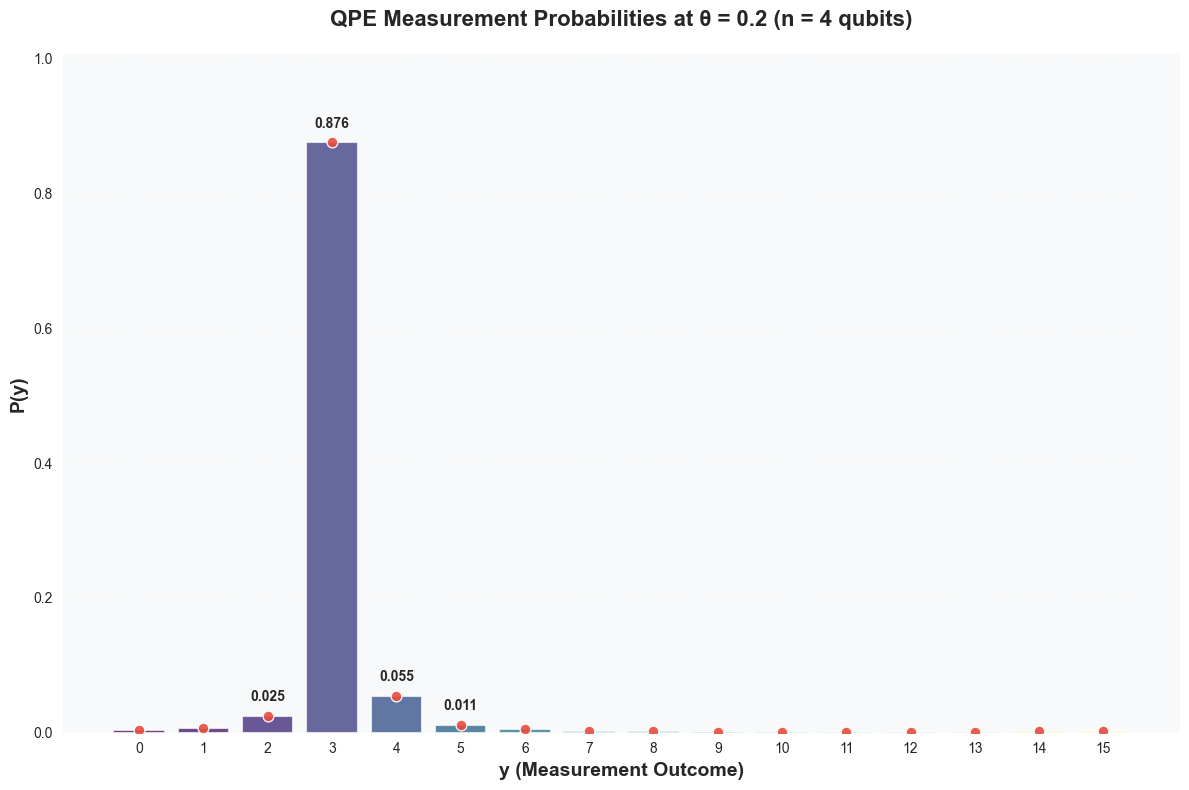

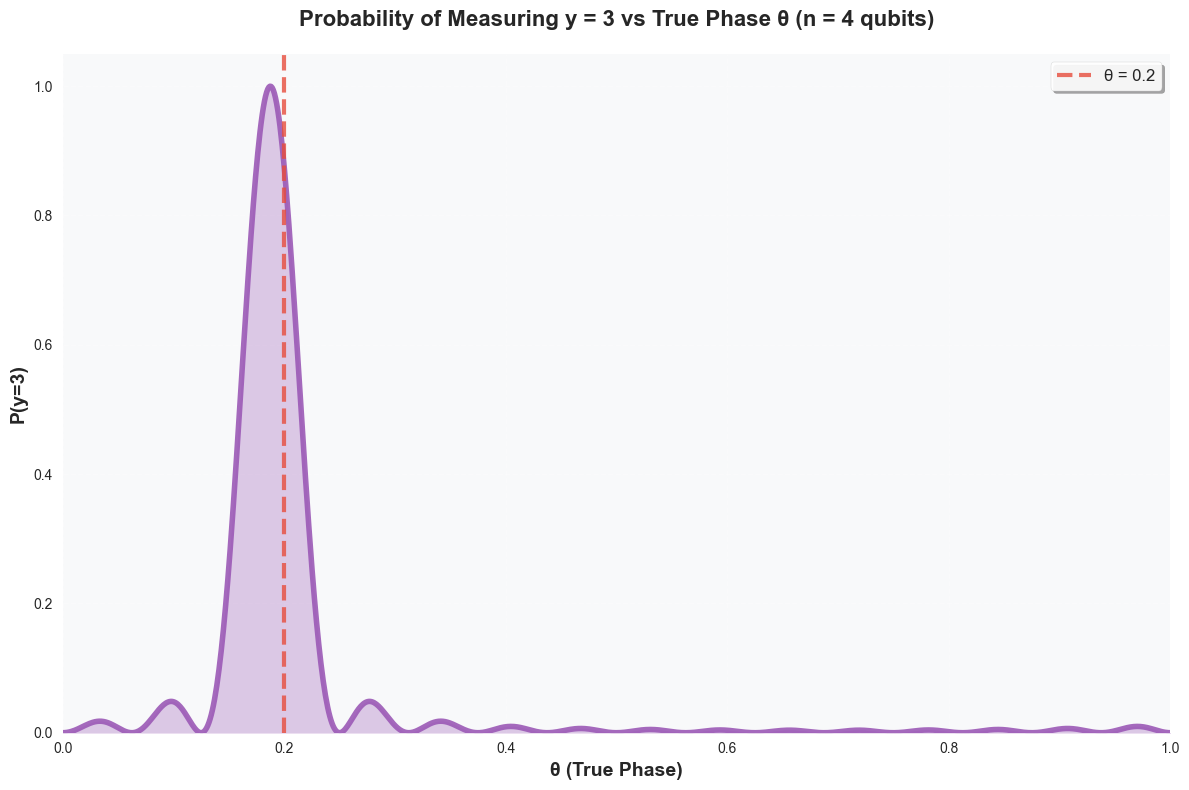

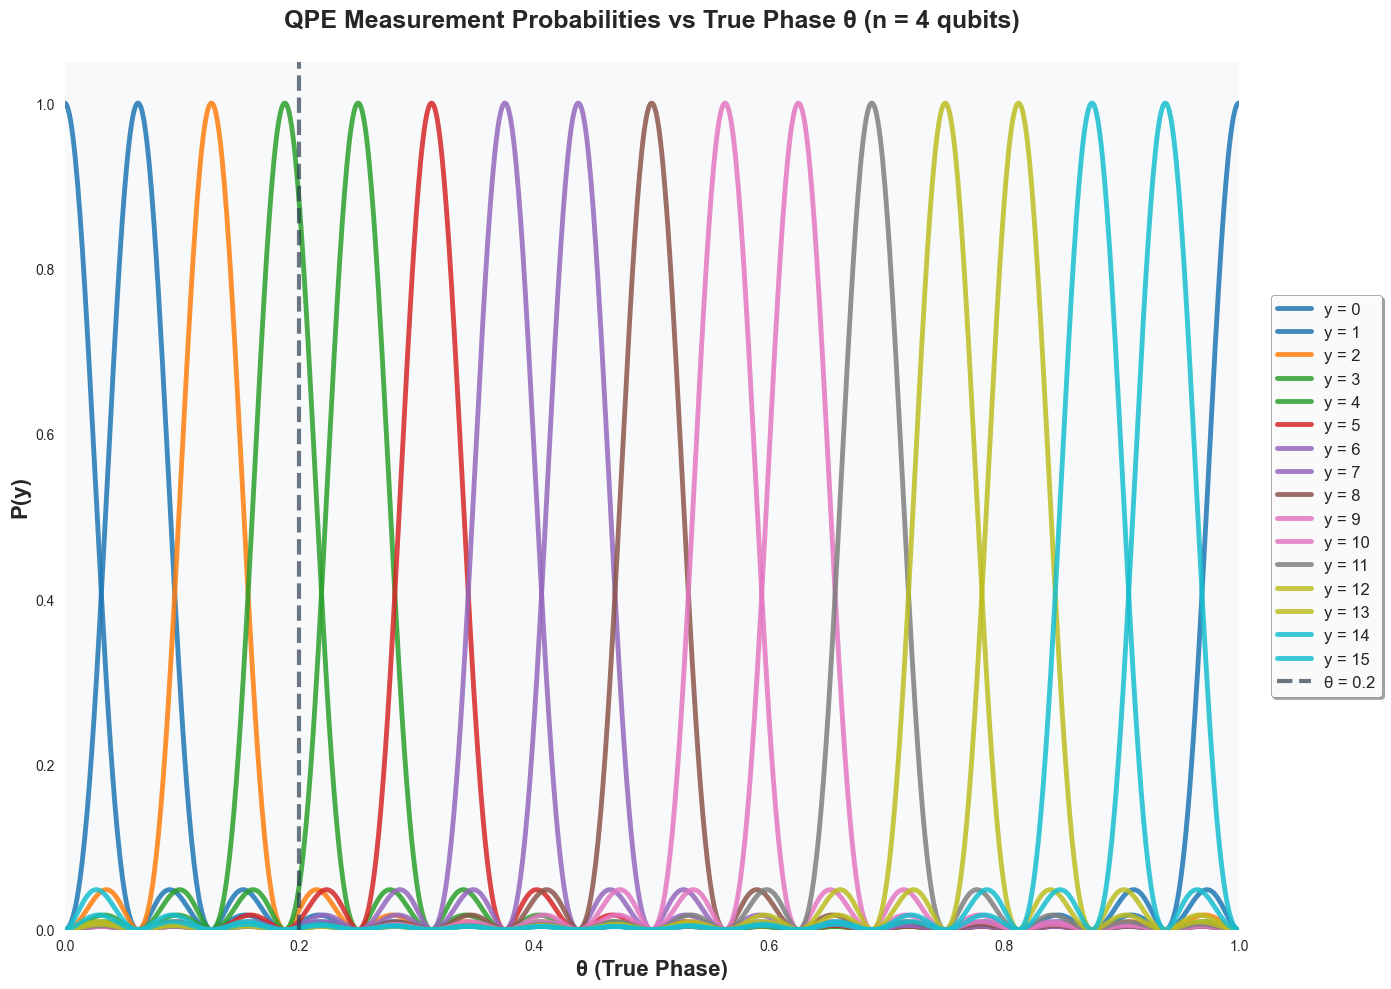

In [10]:
# --- Setup for plotting QPE probabilities ---
def qpe_prob(k, n, theta):
    N = 2**n
    delta = theta - k/N
    if np.isclose(delta, 0):
        return 1.0
    numerator = np.sin(np.pi * N * delta)
    denominator = N * np.sin(np.pi * delta)
    return (numerator / denominator)**2

n = 4  # Number of qubits
Nval = 2**n  # Number of measurement outcomes

plt.style.use('seaborn-v0_8')
colors_palette = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#8E44AD', '#27AE60']

# ---- 1. Plot of all states probabilities for theta = 0.2 ----
theta_fixed = 0.2
ys = np.arange(Nval)
probs = [qpe_prob(y, n, theta_fixed) for y in ys]

plt.figure(figsize=(12, 8))

# Create bars and scatter points
colors = plt.cm.viridis(np.linspace(0, 1, len(ys)))
bars = plt.bar(ys, probs, color=colors, alpha=0.8, edgecolor='white', linewidth=1.5)
plt.scatter(ys, probs, color='#E74C3C', s=60, zorder=5, alpha=0.9, edgecolors='white', linewidth=1)

# Add value labels on bars
for i, (y, prob) in enumerate(zip(ys, probs)):
    if prob > 0.01:  # Only label significant probabilities
        plt.text(y, prob + max(probs) * 0.02, f'{prob:.3f}', ha='center', va='bottom', 
                fontsize=10, fontweight='bold')

plt.xlabel("y (Measurement Outcome)", fontsize=14, fontweight='bold')
plt.ylabel("P(y)", fontsize=14, fontweight='bold')
plt.title(f"QPE Measurement Probabilities at θ = {theta_fixed} (n = {n} qubits)", 
          fontsize=16, fontweight='bold', pad=20)

# Grid and background
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.grid(True, axis='x', linestyle=':', alpha=0.2)
plt.gca().set_facecolor('#f8f9fa')

plt.xticks(ys)
plt.ylim(0, max(probs) * 1.15)
plt.tight_layout()
plt.show()

# ---- 2. Plot of single y vs theta ----
y_fixed = 3
thetas = np.linspace(0, 1, 1000)
probs_y = [qpe_prob(y_fixed, n, theta) for theta in thetas]

plt.figure(figsize=(12, 8))

# Line plot with fill
plt.plot(thetas, probs_y, linewidth=4, color='#9B59B6', alpha=0.9, zorder=3)
plt.fill_between(thetas, probs_y, alpha=0.3, color='#9B59B6', zorder=2)

# Reference line at theta = 0.2
plt.axvline(x=0.2, color='#E74C3C', linestyle='--', linewidth=3, alpha=0.8, 
           label='θ = 0.2', zorder=4)

plt.gca().set_facecolor('#f8f9fa')

plt.xlabel("θ (True Phase)", fontsize=14, fontweight='bold')
plt.ylabel(f"P(y={y_fixed})", fontsize=14, fontweight='bold')
plt.title(f"Probability of Measuring y = {y_fixed} vs True Phase θ (n = {n} qubits)", 
          fontsize=16, fontweight='bold', pad=20)

plt.grid(True, linestyle='--', alpha=0.3, zorder=1)

# Legend
legend = plt.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)

plt.xlim(0, 1)
plt.ylim(0, max(probs_y) * 1.05)
plt.tight_layout()
plt.show()

# ---- 3. Plot of all y vs theta ----
thetas = np.linspace(0, 1, 1000)

plt.figure(figsize=(14, 10))
plt.gca().set_facecolor('#f8f9fa')

# Use different colors for each y value
colors = plt.cm.tab10(np.linspace(0, 1, Nval))
for y in range(Nval):
    probs_y = [qpe_prob(y, n, theta) for theta in thetas]
    plt.plot(thetas, probs_y, label=f'y = {y}', color=colors[y], 
            linewidth=3.5, alpha=0.85, zorder=3)

# Add vertical line at theta = 0.2 with enhanced styling
plt.axvline(x=0.2, color='#2C3E50', linestyle='--', linewidth=3, 
           alpha=0.7, label='θ = 0.2', zorder=4)

plt.xlabel("θ (True Phase)", fontsize=16, fontweight='bold')
plt.ylabel("P(y)", fontsize=16, fontweight='bold')
plt.title(f"QPE Measurement Probabilities vs True Phase θ (n = {n} qubits)", 
          fontsize=18, fontweight='bold', pad=25)

# Legend positioning
legend = plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=12, 
                   ncol=1, frameon=True, fancybox=True, shadow=True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.95)
legend.get_frame().set_edgecolor('gray')
legend.get_frame().set_linewidth(0.5)

# Grid
plt.grid(True, linestyle='--', alpha=0.3, zorder=1)
plt.grid(True, linestyle=':', alpha=0.2, which='minor', zorder=1)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

# Reset to default style if needed
plt.style.use('default')

## QPE Implementation and Simulation

Now we'll implement the Quantum Phase Estimation algorithm and run simulations to verify our theoretical predictions.

In [3]:
# Create a custom unitary gate U
# R_ϕ(2π/5) gate which has an eigenvector of |1⟩, phase angle theta of 0.2
class UGate(Gate):
    def __init__(self):
        super().__init__('U', 1, [])  # name, num_qubits, params
    
    def _define(self):
        # Define the gate using basic gates
        qc = QuantumCircuit(1)
        # R_ϕ(2π/5) gate: applies phase e^(i*2π/5) to |1⟩ state
        qc.p(2*np.pi/5, 0)  # Phase gate with angle 2π/5
        self.definition = qc

# Create an instance of the custom gate
u_gate = UGate()

In [4]:
# For R_ϕ(2π/5) gate, the eigenstate is |1⟩
# The matrix for R_ϕ(θ) is:
# [[1, 0], [0, e^(iθ)]]
theta = 2*np.pi/5
R_phi = np.array([
    [1, 0],
    [0, np.exp(1j*theta)]
])

eigvals, eigvecs = np.linalg.eig(R_phi)

# For R_ϕ gate, |1⟩ is an eigenstate with eigenvalue e^(iθ)
eigenstate = np.array([0, 1])  # |1⟩ state
expected_eigenvalue = theta/(2*np.pi)
print("Eigenvector |1⟩:", eigenstate)
print("Eigenvalues:", eigvals)
print("Expected phase:", expected_eigenvalue)

Eigenvector |1⟩: [0 1]
Eigenvalues: [1.        +0.j         0.30901699+0.95105652j]
Expected phase: 0.2


In [5]:
def QPE(u_gate, n, prepare_eigenstate=False, eigenstate=None):
    """
    Quantum Phase Estimation (QPE) algorithm implementation.
    This function sets up the quantum circuit for QPE for a specific unitary gate U and n control qubits.

    Parameters:
    u_gate (Gate): The unitary gate U to be estimated.
    n (int): The number of control qubits.
    prepare_eigenstate (bool): If True, prepares the target qubit in the eigenstate of U.
    eigenstate (array): The eigenstate to prepare in the target qubit if prepare_eigenstate is True.
    Returns:
    QuantumCircuit: The quantum circuit implementing the QPE algorithm.
    """

    # Create quantum and classical registers
    control_qubits = QuantumRegister(n, '|0⟩')
    target_qubit = QuantumRegister(1, '|ψ⟩')
    classical_bits = ClassicalRegister(n, 'classical')

    # Create the quantum circuit
    circuit = QuantumCircuit(control_qubits, target_qubit, classical_bits)

    # Step 0: Prepare the target qubit in the eigenstate |ψ⟩
    if prepare_eigenstate:
        # Assuming the target qubit is prepared in the eigenstate of U
        # For example, if U is a rotation gate, we can prepare the state accordingly
        circuit.initialize(eigenstate, target_qubit[0])
        circuit.barrier()

    # Step 1: Prepare the control qubits in state |+⟩
    for i in range(n):
        circuit.h(control_qubits[i])

    # Step 2: Apply controlled-U operations
    for i in range(n):
        # Apply U^(2^(n-1-i)) controlled by the i-th control qubit
        for _ in range(2**(n-1-i)):
            circuit.append(u_gate.control(), [control_qubits[i], target_qubit[0]])
    
    circuit.barrier()

    # Step 3: Apply inverse QFT (not implemented here)
    inv_qft = QFT(n, do_swaps=False).inverse()
    inv_qft.name = "IQFT"
    circuit.append(inv_qft, control_qubits[:])

    # Step 4: Measure the control qubits
    for i in range(n):
        circuit.measure(control_qubits[i], classical_bits[i])

    return circuit

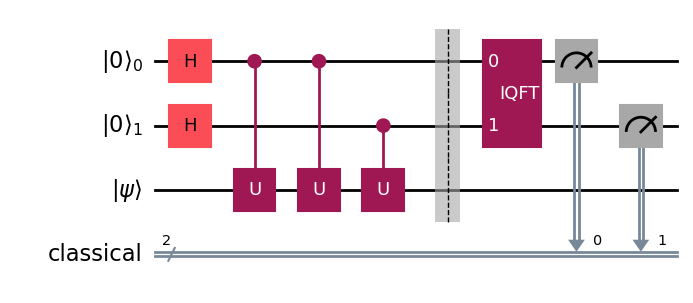

In [6]:
circuit = QPE(u_gate, 2)  # Example with 2 control qubits
circuit.draw('mpl')

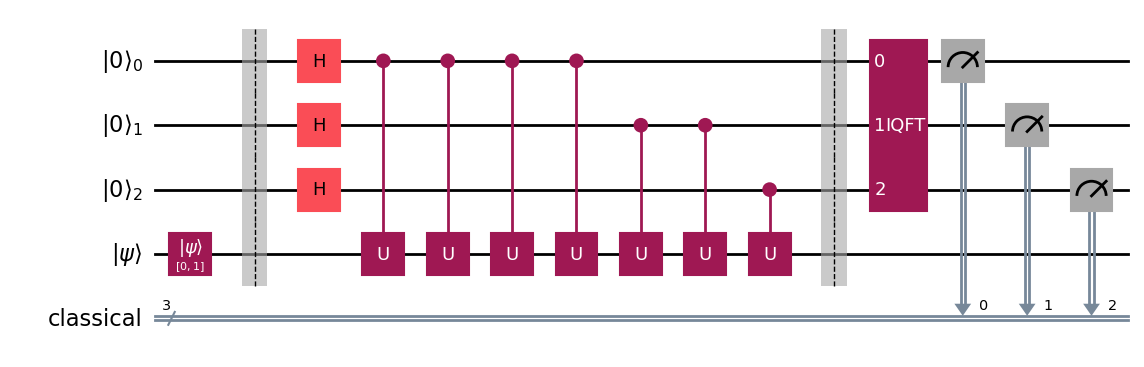

In [7]:
circuit = QPE(u_gate, 3, prepare_eigenstate=True, eigenstate=eigenstate)  # Example with 3 control qubits and eigenstate preparation
circuit.draw('mpl')

Results:
[('0000', 0.00390625), ('0001', 0.008544921875), ('0010', 0.02294921875), ('0011', 0.869140625), ('0100', 0.065185546875), ('0101', 0.011474609375), ('0110', 0.0029296875), ('0111', 0.00244140625), ('1000', 0.001953125), ('1001', 0.001220703125), ('1010', 0.0009765625), ('1011', 0.0009765625), ('1100', 0.001220703125), ('1101', 0.002685546875), ('1110', 0.00244140625), ('1111', 0.001953125)]


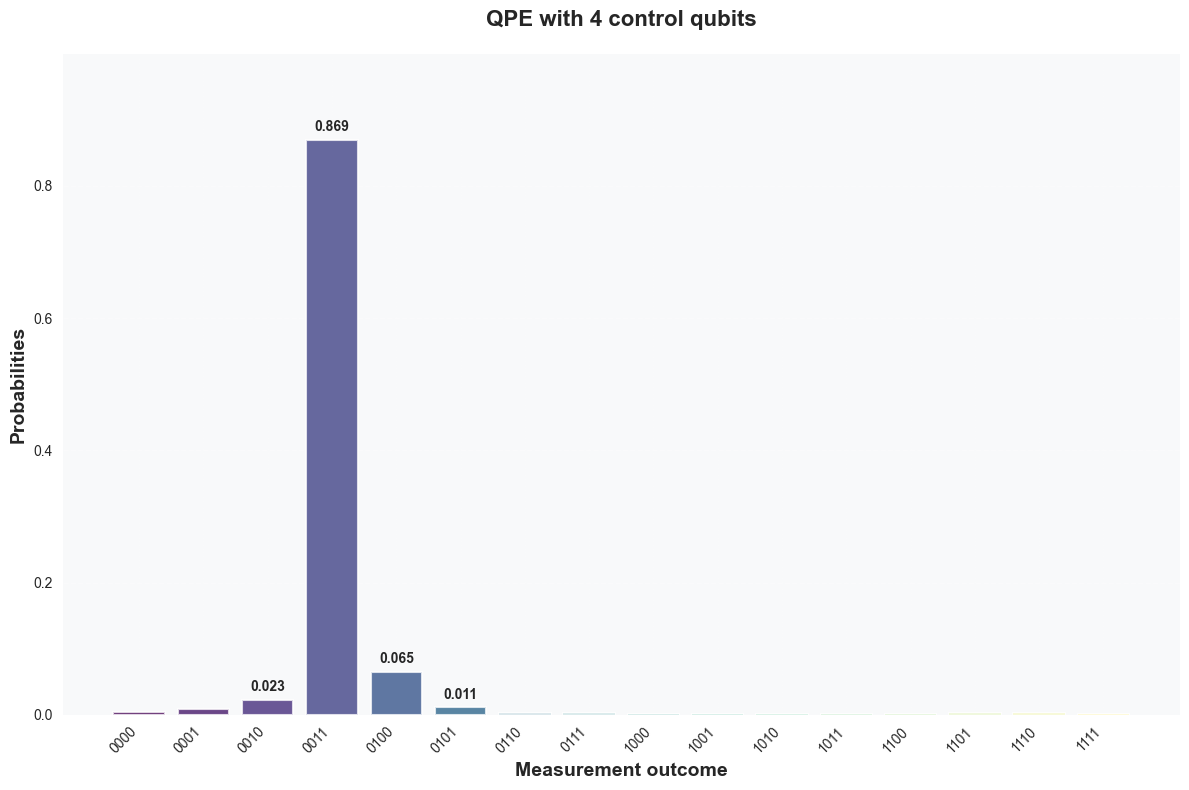


Phase Analysis:
Number of control qubits: 4
Eigenstate: [0 1]
Expected phase: 0.2

Most likely outcome: 0011
Estimated phase: 0.18750
Percentage error: 6.25000%
Count: 3560
Probability: 0.86914


In [8]:
# Use the basic provider and simulator
provider = BasicProvider()
backend = provider.get_backend('basic_simulator')

# Number of control qubits
n_control_qubits = 4

# Simulate the circuit with eigenstate preparation
circuit1 = QPE(u_gate, n_control_qubits, prepare_eigenstate=True, eigenstate=eigenstate)
transpiled_circuit1 = transpile(circuit1, backend)

# Run simulation
shots = 2**12
job1 = backend.run(transpiled_circuit1, shots=shots)
result1 = job1.result()
counts1 = result1.get_counts()

# Sort the outcomes by their binary value (now correctly ordered) qiskit is little-endian, python is big-endian.
sorted_outcomes = sorted(counts1.keys(), key=lambda x: int(x, 2))
sorted_probabilities = [counts1[outcome]/shots for outcome in sorted_outcomes]

print("Results:")
print(list(zip(sorted_outcomes, sorted_probabilities)))

# Plot results with enhanced styling
plt.figure(figsize=(12, 8))
plt.style.use('seaborn-v0_8')

# Create bars
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_outcomes)))
bars = plt.bar(sorted_outcomes, sorted_probabilities, 
               color=colors, alpha=0.8, edgecolor='white', 
               linewidth=1.5, capsize=5)

# Add value labels for significant probabilities
for i, (outcome, prob) in enumerate(zip(sorted_outcomes, sorted_probabilities)):
    if prob > 0.01:  # Only label significant probabilities
        plt.text(i, prob + max(sorted_probabilities) * 0.01, 
                f'{prob:.3f}', ha='center', va='bottom', 
                fontsize=10, fontweight='bold')

plt.title(f'QPE with {n_control_qubits} control qubits', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Measurement outcome', fontsize=14, fontweight='bold')
plt.ylabel('Probabilities', fontsize=14, fontweight='bold')

plt.xticks(rotation=45, ha='right')

# Grid and background
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.grid(True, axis='x', linestyle=':', alpha=0.2)

plt.gca().set_facecolor('#f8f9fa')

plt.tight_layout()
plt.ylim(0, max(sorted_probabilities) * 1.15)

plt.show()

plt.style.use('default')
# Analyze the phase estimation
print("\nPhase Analysis:")
print(f"Number of control qubits: {n_control_qubits}")
print(f"Eigenstate: {eigenstate}")
print(f"Expected phase: {expected_eigenvalue}")

# Convert measurement outcomes to estimated phases
# Find the outcome with the most counts (using corrected counts)
most_likely_outcome = max(counts1, key=counts1.get)
most_likely_count = counts1[most_likely_outcome]

# Convert binary string to decimal (already in correct big-endian format)
decimal_value = int(most_likely_outcome, 2)
# Estimate phase
estimated_phase = decimal_value / (2**n_control_qubits)
print()
print(f"Most likely outcome: {most_likely_outcome}")
print(f"Estimated phase: {estimated_phase:.5f}")
print(f"Percentage error: {abs(estimated_phase - expected_eigenvalue) / expected_eigenvalue * 100:.5f}%")
print(f"Count: {most_likely_count}")
print(f"Probability: {most_likely_count/shots:.5f}")

## n Unitary Hadamard Test

This section shows the probability measurements with 1 qubit applying n Unitaries.

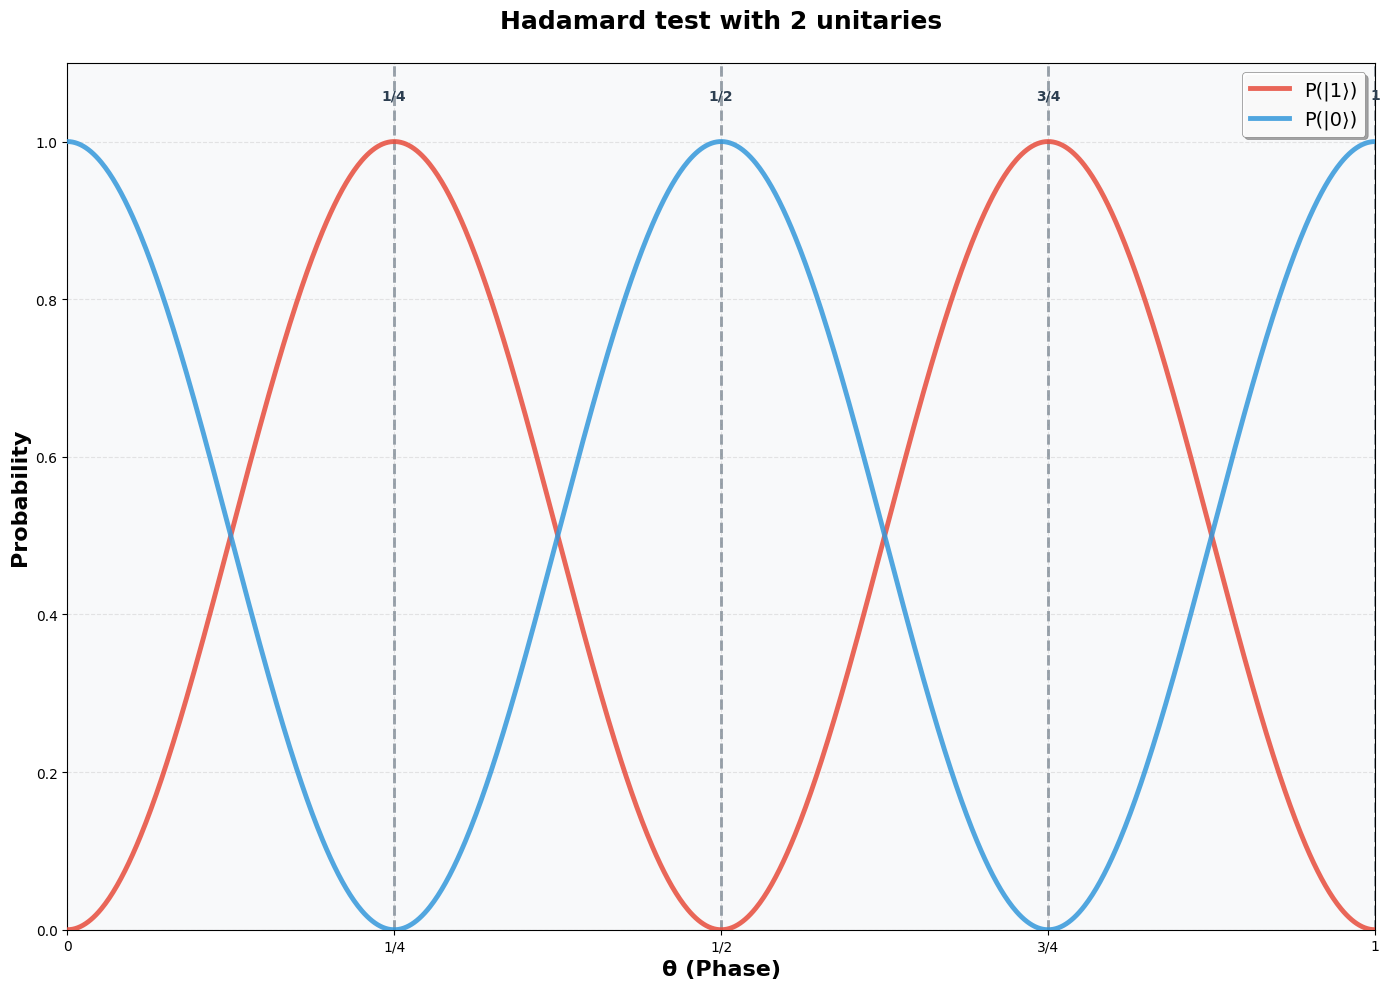

In [9]:
# Define parameter n for the trigonometric functions
n_param = 2  # Parameter for sin²(nπθ) and cos²(nπθ)

# Generate theta values from 0 to 1 for better visualization of trigonometric functions
theta_range = np.linspace(0, 1, 1000)

# Calculate sin²(nπθ) and cos²(nπθ)
sin_squared = np.sin(n_param * np.pi * theta_range)**2
cos_squared = np.cos(n_param * np.pi * theta_range)**2

plt.figure(figsize=(14, 10))
plt.gca().set_facecolor('#f8f9fa')

# Plot probability curves
plt.plot(theta_range, sin_squared, label=f'P(|1⟩)', 
         color='#E74C3C', linewidth=3.5, alpha=0.85, zorder=3)
plt.plot(theta_range, cos_squared, label=f'P(|0⟩)', 
         color='#3498DB', linewidth=3.5, alpha=0.85, zorder=3)

# Add vertical lines at key phase values (0.25, 0.5, 0.75, 1.0)
key_phases = [0.25, 0.5, 0.75, 1.0]
phase_labels = ['1/4', '1/2', '3/4', '1']
# Add reference lines at key phase values
for i, (phase, label) in enumerate(zip(key_phases, phase_labels)):
    plt.axvline(x=phase, color='#2C3E50', linestyle='--', linewidth=2, 
               alpha=0.5, zorder=1)
    # Add phase labels
    plt.text(phase, 1.05, label, ha='center', va='bottom', 
             fontsize=10, fontweight='bold', color='#2C3E50')
plt.xlabel("θ (Phase)", fontsize=16, fontweight='bold')
plt.ylabel("Probability", fontsize=16, fontweight='bold')
plt.title(f"Hadamard test with {n_param} unitaries", 
          fontsize=18, fontweight='bold', pad=25)

# Legend
legend = plt.legend(loc='upper right', fontsize=14, 
                   frameon=True, fancybox=True, shadow=True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.95)
legend.get_frame().set_edgecolor('gray')
legend.get_frame().set_linewidth(0.5)

# Grid
plt.grid(True, linestyle='--', alpha=0.3, zorder=1)
plt.grid(True, linestyle=':', alpha=0.2, which='minor', zorder=1)
# Set axis limits and ticks
plt.xlim(0, 1)
plt.ylim(0, 1.1)

# Custom x-axis ticks for better readability
x_ticks = [0, 0.25, 0.5, 0.75, 1.0]
x_tick_labels = ['0', '1/4', '1/2', '3/4', '1']
plt.xticks(x_ticks, x_tick_labels)

plt.tight_layout()
plt.show()

plt.style.use('default')